# Pipeline 
This notebook processes imported quotes (namely discards duplicates and quotes that are too similar) and extracts the topics using a Latent Dirichlet Allocation Process.

The quotes processed are about Tesla, Chevrolet, but also treats Toyota. We chose not to publish the results about the latter to keep the data story clear and concise. Indeed, it didn't bring new ideas or significantly different results compared to Tesla and Chevrolet, even though the profile was interesting.

In [1]:
from google.colab import drive
import pathlib 
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/My Drive/ADA/Project/"

Mounted at /content/drive
/content/drive/My Drive/ADA/Project


In [2]:
import re
import numpy as np
import pandas as pd

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from gensim import corpora

import gensim 
from PIL import Image
import matplotlib.pyplot as plt


Import the data

In [3]:
path = pathlib.Path('Bastien.ipynb').parent.resolve()
path_to_quotes = str(path) + '/data/Tesla-quotes-2015.json' 
quotes_Tesla_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2016.json' 
quotes_Tesla_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2017.json' 
quotes_Tesla_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2018.json' 
quotes_Tesla_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2019.json' 
quotes_Tesla_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2020.json' 
quotes_Tesla_2020 = pd.read_json(path_or_buf = path_to_quotes) 


################################################################################
path_to_quotes = str(path) + '/data/Chevy-quotes-2015.json' 
quotes_Chevy_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2016.json' 
quotes_Chevy_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2017.json' 
quotes_Chevy_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2018.json' 
quotes_Chevy_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2019.json' 
quotes_Chevy_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2020.json' 
quotes_Chevy_2020 = pd.read_json(path_or_buf = path_to_quotes) 

# ###################################################################
# # Analysis was also performed with Toyota 
# path_to_quotes = str(path) + '/data/Toyota-quotes-2015.json' 
# quotes_Toyota_2015 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Toyota-quotes-2016.json' 
# quotes_Toyota_2016 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Toyota-quotes-2017.json' 
# quotes_Toyota_2017 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Toyota-quotes-2018.json' 
# quotes_Toyota_2018 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Toyota-quotes-2019.json' 
# quotes_Toyota_2019 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Toyota-quotes-2020.json' 
# quotes_Toyota_2020 = pd.read_json(path_or_buf = path_to_quotes) 

In [4]:
def clean(text):
  ''' Input : text (string)
      Output: text (string)
  Removes all special characters, punctuation and spaces from the text'''

  text = re.sub('[^A-Za-z]+', ' ', text)
  return text

def listToString(s): 
  ''' Input : s (list)
      Output : string
  Transforms a list of words to a string '''
  str1 = " " 
  return (str1.join(s))

def processing(quotes):
  ''' Input : quotes (list)
      Outputs: * tokenized (list of tokenised strings)
               * stop_rmvd_string (list of string with stopwords removed)
  Tokenises and removes stopwords from texts in list'''

  tokenized = []
  stop_rmvd_string = []

  for sentence in quotes:
    tokens = [token.text for token in nlp(sentence)]
    tokenized.append(tokens)
    contractions =     ['s',' ve ', 've','ll', ' ll ',' t ','Chevrolet', 'Tesla', 'model', 'Model', 't', 'like', 'car', 'Toyota']
    # Tesla deleted : 'like', 'model'
    # Chevrolet deleted : 'car', 'race' 
    # Toyota deleted : 'race' 
 
    stop_words = [token.text for token in nlp(sentence) if not token.is_stop ]
    stop_words = [word for word in stop_words if word not in contractions]

    stop_rmvd_string.append(listToString(stop_words))

  return tokenized, stop_rmvd_string

def reduce_quotes(vectorizer, dataframe) :
  ''' Input : * vectorizer (Object used for building TF IDF)
              * dataframe  ( Pandas dataframe)
      Ouput : dataframe (Pandas dataframe)
      Computes and uses TF-IDF matrix to remove quotes which seem too similar'''

  dataframe = dataframe.drop_duplicates(subset = ['quotation'])
  tfid = vectorizer.fit_transform(dataframe["quotation"])
  pairwise_similarity = (tfid * tfid.T).toarray()
  
  duplicates_id = []
  index = dataframe.index

  i = 0
  for quote in pairwise_similarity:
      for val in range(i, len(quote)):
          if (quote[val] > 0.7) and (i != val):

              duplicates_id.append(index[val])
      i += 1

  duplicates_id = list(set(duplicates_id))
  duplicates_id.sort()
  dataframe = dataframe.drop(duplicates_id, axis = 0)
  return dataframe

nlp = spacy.load('en')


def clean_df (dataframe, vectorizer,filename):
  ''' Inputs  : * dataframe (Pandas dataframe)
                * vectorizer (Object used for TF IDF matrix building)
                * filename (string, path to save location)
      Outputs : dataframe (Pandas Dataframe)
      Reduces the quote sample, tokenizes and removes stopwords'''

  dataframe['Cleaned Reviews'] = dataframe['quotation'].apply(clean)
  tokenized, rmvd_string = processing(dataframe["Cleaned Reviews"])
  dataframe['Tokenized'] = tokenized
  dataframe['Stop Words Removed'] = rmvd_string 
  dataframe = reduce_quotes(vectorizer, dataframe)
  filename = 'data/'+ filename
  dataframe.to_json(path_or_buf=filename) #if you want a compression, you can add the type directly in the filename among these : {‘infer’, ‘gzip’, ‘bz2’, ‘zip’, ‘xz’, None}
  return dataframe

def LDA(dataframe, number_topics) :
  ''' Inputs : * dataframe (Pandas dataframe)
               * number_topics (integer)
      Outputs: * ldas (topics from LDA, formatted following gensim format)
  Performs LDA on a preprocessed dataset. The stopwords must have been removed and duplicates discarded'''

  # greatly inspired by https://www.pluralsight.com/guides/topic-identification-nlp
  Lda_object = gensim.models.ldamulticore.LdaModel

  dataframe['Year'] = dataframe['date'].dt.year
  years = dataframe.Year.unique()
  ldas = np.empty((len(years), 12), dtype=list) # number of year x number of months in a year

  for i in range(len(years)) :
    y = years[i]
    quotes = dataframe.loc[dataframe.Year == y]
    for m in range(1,13) :
      quotes_month = quotes.loc[quotes['date'].dt.month == m]
      final_doc = [quote.split() for quote in quotes_month['Stop Words Removed']]
      if final_doc ==[] :
        continue
      dictionary = corpora.Dictionary(final_doc)
      DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
      lda_model = Lda_object(DT_matrix, num_topics=number_topics, id2word = dictionary)
      ldas[i,m-1] = lda_model.print_topics(num_topics=2, num_words=6)
    
  return ldas

**WARNING** : If the data has already been processed in the past, skip the following cell and go straight to the next one.

In [5]:
# WARNING : If the data has already been processed, skip this cell

vectorizer = TfidfVectorizer() # choice of TF IDF  vectorizer
print('Clean Chevy dataframes')
quotes_Chevy_2015 = clean_df(quotes_Chevy_2015,vectorizer,'Chevy-quotes-2015.json')
quotes_Chevy_2016 = clean_df(quotes_Chevy_2016,vectorizer,'Chevy-quotes-2016.json')
quotes_Chevy_2017 = clean_df(quotes_Chevy_2017,vectorizer,'Chevy-quotes-2017.json')
quotes_Chevy_2018 = clean_df(quotes_Chevy_2018,vectorizer,'Chevy-quotes-2018.json')
quotes_Chevy_2019 = clean_df(quotes_Chevy_2019,vectorizer,'Chevy-quotes-2019.json')
quotes_Chevy_2020 = clean_df(quotes_Chevy_2020,vectorizer,'Chevy-quotes-2020.json')

print('Clean Tesla dataframes')
quotes_Tesla_2015 = clean_df(quotes_Tesla_2015,vectorizer,'Tesla-quotes-2015.json')
quotes_Tesla_2016 = clean_df(quotes_Tesla_2016,vectorizer,'Tesla-quotes-2016.json')
quotes_Tesla_2017 = clean_df(quotes_Tesla_2017,vectorizer,'Tesla-quotes-2017.json')
quotes_Tesla_2018 = clean_df(quotes_Tesla_2018,vectorizer,'Tesla-quotes-2018.json')
quotes_Tesla_2019 = clean_df(quotes_Tesla_2019,vectorizer,'Tesla-quotes-2019.json')
quotes_Tesla_2020 = clean_df(quotes_Tesla_2020,vectorizer,'Tesla-quotes-2020.json')


# print('clean Toyota dataframes')
# quotes_Toyota_2015 = clean_df(quotes_Toyota_2015,vectorizer,'Toyota-quotes-2015.json')
# quotes_Toyota_2016 = clean_df(quotes_Toyota_2016,vectorizer,'Toyota-quotes-2016.json')
# quotes_Toyota_2017 = clean_df(quotes_Toyota_2017,vectorizer,'Toyota-quotes-2017.json')
# quotes_Toyota_2018 = clean_df(quotes_Toyota_2018,vectorizer,'Toyota-quotes-2018.json')
# quotes_Toyota_2019 = clean_df(quotes_Toyota_2019,vectorizer,'Toyota-quotes-2019.json')
# quotes_Toyota_2020 = clean_df(quotes_Toyota_2020,vectorizer,'Toyota-quotes-2020.json')



Clean Chevy dataframes
Clean Tesla dataframes


In [6]:
# # # If the cleaning phase has already been done, this cell allows to fetch the data and skip the previous cells 
# path = pathlib.Path('Bastien.ipynb').parent.resolve()
# path_to_quotes = str(path) + '/data/Tesla-quotes-2015.json' 
# quotes_Tesla_2015 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Tesla-quotes-2016.json' 
# quotes_Tesla_2016 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Tesla-quotes-2017.json' 
# quotes_Tesla_2017 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Tesla-quotes-2018.json' 
# quotes_Tesla_2018 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Tesla-quotes-2019.json' 
# quotes_Tesla_2019 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Tesla-quotes-2020.json' 
# quotes_Tesla_2020 = pd.read_json(path_or_buf = path_to_quotes) 


# ################################################################################
# path_to_quotes = str(path) + '/data/Chevy-quotes-2015.json' 
# quotes_Chevy_2015 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Chevy-quotes-2016.json' 
# quotes_Chevy_2016 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Chevy-quotes-2017.json' 
# quotes_Chevy_2017 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Chevy-quotes-2018.json' 
# quotes_Chevy_2018 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Chevy-quotes-2019.json' 
# quotes_Chevy_2019 = pd.read_json(path_or_buf = path_to_quotes) 

# path_to_quotes = str(path) + '/data/Chevy-quotes-2020.json' 
# quotes_Chevy_2020 = pd.read_json(path_or_buf = path_to_quotes) 

# # #################################################################################
# # path_to_quotes = str(path) + '/data/Toyota-quotes-2015.json' 
# # quotes_Toyota_2015 = pd.read_json(path_or_buf = path_to_quotes) 

# # path_to_quotes = str(path) + '/data/Toyota-quotes-2016.json' 
# # quotes_Toyota_2016 = pd.read_json(path_or_buf = path_to_quotes) 

# # path_to_quotes = str(path) + '/data/Toyota-quotes-2017.json' 
# # quotes_Toyota_2017 = pd.read_json(path_or_buf = path_to_quotes) 

# # path_to_quotes = str(path) + '/data/Toyota-quotes-2018.json' 
# # quotes_Toyota_2018 = pd.read_json(path_or_buf = path_to_quotes) 

# # path_to_quotes = str(path) + '/data/Toyota-quotes-2019.json' 
# # quotes_Toyota_2019 = pd.read_json(path_or_buf = path_to_quotes) 

# # path_to_quotes = str(path) + '/data/Toyota-quotes-2020.json' 
# # quotes_Toyota_2020 = pd.read_json(path_or_buf = path_to_quotes) 

We stack all the quotes together for later processes

In [7]:
df_chevy = quotes_Chevy_2015
df_chevy = df_chevy.append(quotes_Chevy_2015)
df_chevy = df_chevy.append(quotes_Chevy_2016)
df_chevy = df_chevy.append(quotes_Chevy_2017)
df_chevy = df_chevy.append(quotes_Chevy_2018)
df_chevy = df_chevy.append(quotes_Chevy_2019)
df_chevy = df_chevy.append(quotes_Chevy_2020)
df_chevy.reset_index(inplace=True)

df_tesla = quotes_Tesla_2015
df_tesla = df_tesla.append(quotes_Tesla_2015)
df_tesla = df_tesla.append(quotes_Tesla_2016)
df_tesla = df_tesla.append(quotes_Tesla_2017)
df_tesla = df_tesla.append(quotes_Tesla_2018)
df_tesla = df_tesla.append(quotes_Tesla_2019)
df_tesla = df_tesla.append(quotes_Tesla_2020)
df_tesla.reset_index(inplace=True)

# df_toyota = quotes_Toyota_2015
# df_toyota = df_toyota.append(quotes_Toyota_2015)
# df_toyota = df_toyota.append(quotes_Toyota_2016)
# df_toyota = df_toyota.append(quotes_Toyota_2017)
# df_toyota = df_toyota.append(quotes_Toyota_2018)
# df_toyota = df_toyota.append(quotes_Toyota_2019)
# df_toyota = df_toyota.append(quotes_Toyota_2020)
# df_toyota.reset_index(inplace=True)

In [8]:
topics_chevy = LDA(df_chevy, number_topics = 1)
print(topics_chevy)

[[list([(0, '0.011*"great" + 0.011*"going" + 0.010*"Camaro" + 0.009*"m" + 0.009*"NHRA" + 0.009*"team"')])
  list([(0, '0.013*"great" + 0.012*"race" + 0.010*"team" + 0.009*"m" + 0.008*"good" + 0.007*"going"')])
  list([(0, '0.015*"race" + 0.015*"good" + 0.011*"weekend" + 0.009*"day" + 0.009*"today" + 0.009*"track"')])
  list([(0, '0.012*"good" + 0.011*"race" + 0.010*"track" + 0.009*"great" + 0.008*"m" + 0.007*"team"')])
  list([(0, '0.017*"race" + 0.008*"m" + 0.007*"good" + 0.007*"tomorrow" + 0.007*"team" + 0.007*"lot"')])
  list([(0, '0.014*"race" + 0.011*"good" + 0.008*"track" + 0.008*"lot" + 0.008*"time" + 0.008*"end"')])
  list([(0, '0.010*"track" + 0.009*"race" + 0.008*"good" + 0.008*"run" + 0.007*"weekend" + 0.006*"know"')])
  list([(0, '0.012*"race" + 0.010*"good" + 0.009*"weekend" + 0.009*"going" + 0.008*"team" + 0.007*"great"')])
  list([(0, '0.013*"race" + 0.010*"team" + 0.008*"good" + 0.008*"lot" + 0.008*"m" + 0.007*"weekend"')])
  list([(0, '0.011*"race" + 0.009*"m" + 0.008*

In [9]:
topics_tesla = LDA(df_tesla, number_topics = 1)
print(topics_tesla)

[[list([(0, '0.011*"going" + 0.009*"Northern" + 0.009*"Ireland" + 0.009*"Nightlife" + 0.008*"Belfast" + 0.008*"S"')])
  list([(0, '0.015*"Apple" + 0.007*"cars" + 0.006*"going" + 0.006*"S" + 0.005*"X" + 0.005*"vehicles"')])
  list([(0, '0.014*"S" + 0.011*"cars" + 0.009*"electric" + 0.009*"year" + 0.008*"going" + 0.008*"new"')])
  list([(0, '0.009*"years" + 0.007*"think" + 0.007*"sales" + 0.007*"battery" + 0.007*"S" + 0.007*"new"')])
  list([(0, '0.011*"battery" + 0.007*"don" + 0.007*"people" + 0.007*"S" + 0.007*"year" + 0.006*"Apple"')])
  list([(0, '0.014*"X" + 0.007*"think" + 0.007*"right" + 0.006*"pro" + 0.006*"sure" + 0.006*"brain"')])
  list([(0, '0.012*"X" + 0.011*"cars" + 0.011*"people" + 0.008*"electric" + 0.008*"good" + 0.007*"state"')])
  list([(0, '0.008*"production" + 0.007*"X" + 0.007*"S" + 0.005*"think" + 0.005*"cars" + 0.004*"year"')])
  list([(0, '0.009*"X" + 0.007*"S" + 0.007*"new" + 0.005*"going" + 0.005*"people" + 0.005*"thing"')])
  list([(0, '0.007*"S" + 0.005*"X" +

In [10]:
# topics_toyota = LDA(df_toyota, number_topics = 1)
# print(topics_toyota)

Now we want to isolate the keywords and build a cloud of words representation.

In [11]:
!pip install pygrok
import re 
from pygrok import Grok
import wordcloud as wc


def find_topics (LDA_model_result,number_topics) :
  ''' Input : * LDA_model_result (gensim topics list)
              * number_topics (int, number of topics listed in the topic list)
      Output: topics (list of words )
      From the format of gensim topics, creates an easily readable list of strings. If there are no quotes for a certain month, the month is skipped.'''
  topics = []
  for  i in range(6):
    for j in range(12):
      for k in range(number_topics):
        line = LDA_model_result[i,j]
        if str(type(line)) == "<class 'NoneType'>": # skip month with no quotes
          continue
        else :
          topics.append(line[k])

  for i,topic in enumerate(topics):
    topic = re.sub(r'\d+','',topic[1])
    topic = re.sub(r'[^\w]', ' ', topic)
    topic = topic.split()
    topics[i] = topic
  return topics


def topic2wordcloud (topics,filepath,filename) :
  ''' Inputs : * topics (list of strings)
               * filepath (string, path to save location)
               * filename (string, name of the file) 
      Ouputs : None. The function plots and saves the images directly
      Plots a cloud of words from an input list of strings'''
  for i in range(len(topics)) :
    topics[i] = " ".join(word for word in topics[i])

  text = " ".join(quote for quote in topics)
  cloud = wc.WordCloud(background_color="white", max_words=200, width=800, height=800, random_state=1).generate(text)
  # to recolour the image
  fig = plt.figure(figsize = (10,10))
  plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
  plt.imshow(cloud)
  plt.savefig(filepath + '/' + filename)


  Created wheel for pygrok: filename=pygrok-1.0.0-py3-none-any.whl size=21743 sha256=d225d40b9bc3cf7d47b22248799606a1d8b2b8de09f037967a9eaad415f83094
  Stored in directory: /root/.cache/pip/wheels/14/87/3e/8280163eb2a26e3ba9cf8c2afa88639f5f4e02c62eb8597413
Successfully built pygrok


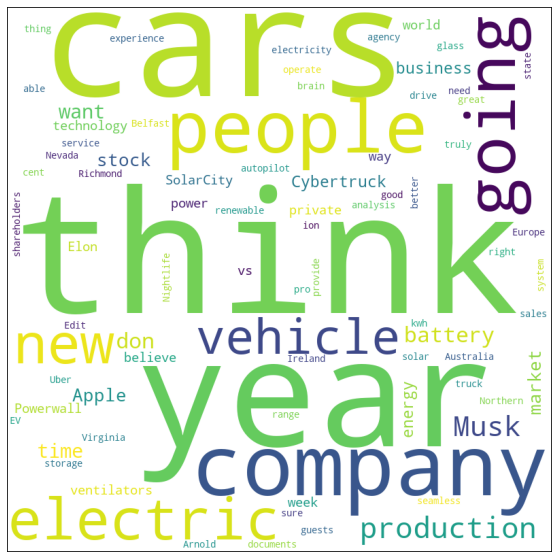

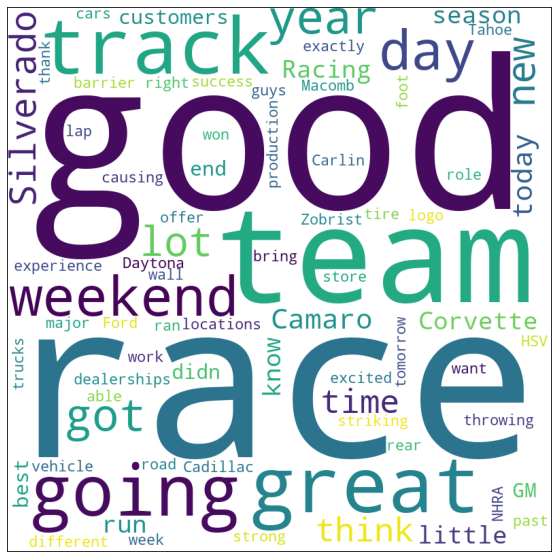

In [12]:
topics_Tesla = find_topics(topics_tesla,1)
topic2wordcloud(topics_Tesla,str(path),'tesla_cloud.png')
topics_Chevy = find_topics(topics_chevy,1)
topic2wordcloud(topics_Chevy,str(path),'chevy_cloud.png')
# topics_To = find_topics(topics_toyota,1)
# topic2wordcloud(topics_To,str(path),'toyota_cloud.png')